In [1]:
!wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
!apt-get update
!apt-get install cuda-9.2

--2021-11-22 11:04:10--  https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64
Resolving developer.nvidia.com (developer.nvidia.com)... 152.195.19.142
Connecting to developer.nvidia.com (developer.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://developer.nvidia.com/compute/cuda/9.2/prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 [following]
--2021-11-22 11:04:11--  https://developer.nvidia.com/compute/cuda/9.2/prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64
Reusing existing connection to developer.nvidia.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.2/secure/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb?6mJFs0T_34c7qQ0zHTufnvfl9xlKkOYSQakUBX3NoRHj1Lomwk3crsxwAU2CWVEHFPy90F1j-d0JQrc3NNjC6-8AhxGNfCDXmrXZNEadsRk9X

In [3]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	:

In [7]:
!pip install numba

In [4]:
!nvidia-smi

Mon Nov 22 11:08:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

In [8]:
from numba import cuda
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32

#Monte-Carlo algorithm <br>


1.   Generate 2 sequences of values - X and Y
2.   Calculate <b>V = X ^ 2 + Y ^ 2</b> for each pair of values
1.   If <b>V < 1</b> return 1 of the vectors V, else return 0
2.   Perform a reduction with sum operator
1.   Multiply the result by <b>4/N</b>









In [35]:
def cpuMonteCarloMethod(size, coef):
  result = 0
  # Generate pair of values for X and Y
  x = np.random.rand(size)
  y = np.random.rand(size)

  for iter in range(size):
    # Caclulate V
    V = x[iter]**2 + y[iter]**2

    if V < 1:
      result += 1
      # or
      # result += coef * 1
    
  return result * coef

In [36]:
@cuda.jit
def gpuMonteCarloMethod(result, coef, states):
  tidx = cuda.threadIdx.x + cuda.blockDim.x * cuda.blockIdx.x
  x = xoroshiro128p_uniform_float32(states, tidx)
  y = xoroshiro128p_uniform_float32(states, tidx)
  V = x**2 + y**2
  if V < 1:
    cuda.atomic.add(result, 0, coef)

In [37]:
"""
Данная ячейка предназначается для инициализации значений для расчета, а так же для запуска функций рачета
"""
sizes = np.array([1024, 1024*2, 1024*4, 1024*8, 1024*16, 1024*32, 1024*64, 1024*128, 1024*512, 1024*1024])
# Количество итераций
iterationsCount = 11
# Размер одного блока
BLOCK_SIZE = 1024

values = {"Размерности":sizes,
          "CPU:Среднее время":np.zeros(len(sizes)),
          "GPU:Среднее время":np.zeros(len(sizes)), 
          "CPU:Среднее отклонение":np.zeros(len(sizes)), 
          "GPU:Среднее отклонение":np.zeros(len(sizes)),
          "CPU Усредненый результат":np.zeros(len(sizes)),
          "GPU Усредненый результат":np.zeros(len(sizes))}


cpuTimeList = list()
cpuCalculPiResult = list()

gpuTimeList = list()
gpuCalculPiResult = list()

for size in range(len(sizes)):

  gridDim = int((sizes[size] + BLOCK_SIZE - 1) / BLOCK_SIZE)
  coef = np.float32(4/sizes[size])

  for iter in range(iterationsCount):
    gpuResults = np.zeros(1, dtype=np.float32)
    startTime = time.time()
    # Создание случайных чисел
    states = create_xoroshiro128p_states(n=gridDim * BLOCK_SIZE, seed=123)
    # Запуск GPU
    gpuMonteCarloMethod[gridDim, BLOCK_SIZE](gpuResults, coef, states)
    stopTime = time.time()
    gpuTimeList.append(stopTime - startTime)
    gpuCalculPiResult.append(gpuResults[0])

    startTime = time.time()
    result = cpuMonteCarloMethod(sizes[size], coef)
    stopTime = time.time()
    cpuTimeList.append(stopTime - startTime)
    cpuCalculPiResult.append(result)
    #print(f"Size = {size}; Iteration = {iter}")
  
  values["CPU:Среднее время"][size] = np.mean(cpuTimeList[1:])
  values["CPU:Среднее отклонение"][size] = np.pi - np.mean(cpuCalculPiResult[1:])
  values["CPU Усредненый результат"][size] = np.mean(cpuCalculPiResult[1:])
  values["GPU:Среднее время"][size] = np.mean(gpuTimeList[1:])
  values["GPU:Среднее отклонение"][size] = np.pi - np.mean(gpuCalculPiResult[1:])
  values["GPU Усредненый результат"][size] = np.mean(gpuCalculPiResult[1:])
  

In [38]:
results = pd.DataFrame(values)
results

,Размерности,CPU:Среднее время,GPU:Среднее время,CPU:Среднее отклонение,GPU:Среднее отклонение,CPU Усредненый результат,GPU Усредненый результат
0,1024,0.001422,0.002071,-0.016220,0.028311,3.157812,3.113281
1,2048,0.002275,0.002111,-0.014471,0.048773,3.156064,3.092820
2,4096,0.003489,0.002220,-0.009225,0.046103,3.150818,3.095490
3,8192,0.005575,0.002546,-0.005562,0.042301,3.147154,3.099291
4,16384,0.009271,0.003265,-0.004494,0.038954,3.146087,3.102638
5,32768,0.015982,0.004629,-0.004420,0.035025,3.146013,3.106567
6,65536,0.028877,0.006874,-0.003595,0.031589,3.145187,3.110004
7,131072,0.050840,0.010659,-0.002939,0.027926,3.144531,3.113667
8,524288,0.131697,0.024590,-0.002534,0.024900,3.144127,3.116693
9,1048576,0.283002,0.050627,-0.002376,0.022525,3.143969,3.119068


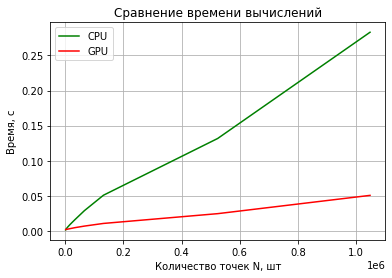

In [39]:
plt.plot(sizes, values["CPU:Среднее время"], color="green", label="CPU")
plt.plot(sizes, values["GPU:Среднее время"], color="red", label="GPU")
plt.title("Сравнение времени вычислений")
plt.xlabel("Количество точек N, шт")
plt.ylabel("Время, с")
plt.grid()
plt.legend()

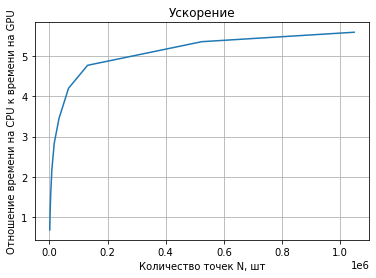

In [40]:
plt.plot(sizes, values["CPU:Среднее время"] / values["GPU:Среднее время"])
plt.title("Ускорение")
plt.xlabel("Количество точек N, шт")
plt.ylabel("Отношение времени на CPU к времени на GPU")
plt.grid()